# YNK forecast

## Import data

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve,auc
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from warnings import simplefilter
from sklearn.linear_model import LassoCV
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [16]:
# Import data in csv from github

# Import data from github
url = 'https://raw.githubusercontent.com/sagebhardt/forecast-AI-ynk/main/DataCleaned.csv'
df = pd.read_csv(url, sep=',')

# Remove '$' from column names
df.columns = df.columns.str.replace('$', '')

#print df size
print(df.shape)

df.head()

(54528, 18)


,Semana,Tienda,Tipo_mat,Grupo_articulos,Sexo,Age_Group,Entradas_Tienda,Venta_U,Stock,Region,Lugar,PIB PC,Infl Anual,T Desempleo,Tasa Interbancaria,Dolar,Venta Bruta,Costo Neto
0,W01,01-Ahumada,ZAPP,AD,Male,Adult,6857,2,89.0,Region Metropolitana,Calle,11.3,0.12,0.08,0.1125,846.38,46790,23194
1,W01,01-Ahumada,ZAPP,NI,Female,Adult,6857,1,118.0,Region Metropolitana,Calle,11.3,0.12,0.08,0.1125,846.38,26990,12520
2,W01,01-Ahumada,ZAPP,NI,Female,Pre School + Grade School,6857,3,18.0,Region Metropolitana,Calle,11.3,0.12,0.08,0.1125,846.38,73680,34777
3,W01,01-Ahumada,ZAPP,NI,Male,Adult,6857,19,270.0,Region Metropolitana,Calle,11.3,0.12,0.08,0.1125,846.38,593950,285666
4,W01,01-Ahumada,ZAPP,NI,Male,Grade School,6857,2,136.0,Region Metropolitana,Calle,11.3,0.12,0.08,0.1125,846.38,38980,18083


## Clean data  

In [17]:
#check for missing values
df.isnull().sum()

Semana                    0
Tienda                    0
Tipo_mat                  0
Grupo_articulos           0
Sexo                   1389
Age_Group              1793
Entradas_Tienda           0
Venta_U                   0
Stock                 16903
Region                    0
Lugar                     0
PIB PC                    0
Infl Anual                0
T Desempleo               0
Tasa Interbancaria        0
Dolar                     0
Venta Bruta               0
Costo Neto                0
dtype: int64

In [18]:
#split features into categorical and numerical
categorical_features = df.select_dtypes(include=['object']).columns
numerical_features = df.select_dtypes(exclude=['object']).columns

print(categorical_features)
print(numerical_features)

Index(['Semana', 'Tienda', 'Tipo_mat', 'Grupo_articulos', 'Sexo', 'Age_Group',
       'Region', 'Lugar'],
      dtype='object')
Index(['Entradas_Tienda', 'Venta_U', 'Stock', 'PIB PC', 'Infl Anual',
       'T Desempleo', 'Tasa Interbancaria', 'Dolar', 'Venta Bruta ',
       'Costo Neto '],
      dtype='object')


In [19]:
df_cat = pd.get_dummies(df[categorical_features], drop_first = True, dummy_na = True)
df_num = df[numerical_features]

from sklearn.impute import SimpleImputer
imp_num = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0, copy=True)
imp_num.fit(df_num)
df_num = pd.DataFrame(imp_num.transform(df_num), columns = df_num.columns)

df_binned = pd.concat([df_num, df_cat], axis = 1)

print(df_binned.shape)

df_binned.head()

(54528, 143)


,Entradas_Tienda,Venta_U,Stock,PIB PC,Infl Anual,T Desempleo,Tasa Interbancaria,Dolar,Venta Bruta,Costo Neto,...,Region_Region de Magallanes,Region_Region de Ohiggins,Region_Region de Tarapaca,Region_Region de Valparaiso,Region_Region de nuble,Region_Region del Maule,Region_nan,Lugar_E-Commerce,Lugar_Mall,Lugar_nan
0,6857.0,2.0,89.0,11.3,0.12,0.08,0.1125,846.38,46790.0,23194.0,...,False,False,False,False,False,False,False,False,False,False
1,6857.0,1.0,118.0,11.3,0.12,0.08,0.1125,846.38,26990.0,12520.0,...,False,False,False,False,False,False,False,False,False,False
2,6857.0,3.0,18.0,11.3,0.12,0.08,0.1125,846.38,73680.0,34777.0,...,False,False,False,False,False,False,False,False,False,False
3,6857.0,19.0,270.0,11.3,0.12,0.08,0.1125,846.38,593950.0,285666.0,...,False,False,False,False,False,False,False,False,False,False
4,6857.0,2.0,136.0,11.3,0.12,0.08,0.1125,846.38,38980.0,18083.0,...,False,False,False,False,False,False,False,False,False,False


In [21]:
#Remove Venta U, Venta Bruta and Costo Neto from numerical features
numerical_features = numerical_features.drop(['Venta_U', 'Venta Bruta ', 'Costo Neto '])

numerical_features

Index(['Entradas_Tienda', 'Stock', 'PIB PC', 'Infl Anual', 'T Desempleo',
       'Tasa Interbancaria', 'Dolar'],
      dtype='object')

In [22]:
#Get features and target
y = df_binned['Venta Bruta ']
X = df_binned.drop(['Venta Bruta ', 'Venta_U', 'Costo Neto '], axis = 1)

features = X.columns

In [23]:
from sklearn.preprocessing import StandardScaler
import warnings; warnings.filterwarnings('ignore')

features = X.copy()
p = features.shape[1]


for var in numerical_features:
    colnam_log = 'log1px2_'+var
    features[colnam_log]=np.log(1+features[var]*features[var])
    
    colnam_sqrt = 'sqrtAbs_'+var
    features[colnam_sqrt]=np.sqrt(np.abs(features[var]))    
                                    
featNames = features.columns.values            

# Scaling the columns to avoid having potential numerical issues as we have some very large numbers
features_scaled = pd.DataFrame(StandardScaler().fit_transform(features), columns = features.columns)

dataProcessed = features_scaled
X = dataProcessed
dataProcessed

,Entradas_Tienda,Stock,PIB PC,Infl Anual,T Desempleo,Tasa Interbancaria,Dolar,Semana_W02,Semana_W03,Semana_W04,...,log1px2_PIB PC,sqrtAbs_PIB PC,log1px2_Infl Anual,sqrtAbs_Infl Anual,log1px2_T Desempleo,sqrtAbs_T Desempleo,log1px2_Tasa Interbancaria,sqrtAbs_Tasa Interbancaria,log1px2_Dolar,sqrtAbs_Dolar
0,0.060016,-0.005557,-0.066643,1.515060,-1.526219,-2.775558e-17,2.176008,-0.284875,-0.280753,-0.283896,...,0.136294,0.026637,1.517178,1.513827,-1.526219,-1.526219,0.0,1.110223e-16,2.150576,2.163289
1,0.060016,0.141424,-0.066643,1.515060,-1.526219,-2.775558e-17,2.176008,-0.284875,-0.280753,-0.283896,...,0.136294,0.026637,1.517178,1.513827,-1.526219,-1.526219,0.0,1.110223e-16,2.150576,2.163289
2,0.060016,-0.365405,-0.066643,1.515060,-1.526219,-2.775558e-17,2.176008,-0.284875,-0.280753,-0.283896,...,0.136294,0.026637,1.517178,1.513827,-1.526219,-1.526219,0.0,1.110223e-16,2.150576,2.163289
3,0.060016,0.911803,-0.066643,1.515060,-1.526219,-2.775558e-17,2.176008,-0.284875,-0.280753,-0.283896,...,0.136294,0.026637,1.517178,1.513827,-1.526219,-1.526219,0.0,1.110223e-16,2.150576,2.163289
4,0.060016,0.232653,-0.066643,1.515060,-1.526219,-2.775558e-17,2.176008,-0.284875,-0.280753,-0.283896,...,0.136294,0.026637,1.517178,1.513827,-1.526219,-1.526219,0.0,1.110223e-16,2.150576,2.163289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54523,-0.980258,-0.132264,-0.066643,-0.793917,0.655214,-2.775558e-17,0.000803,-0.284875,-0.280753,-0.283896,...,0.136294,0.026637,-0.780537,-0.801075,0.655214,0.655214,0.0,1.110223e-16,0.010677,0.005736
54524,-0.980258,-0.350200,-0.066643,-0.793917,0.655214,-2.775558e-17,0.000803,-0.284875,-0.280753,-0.283896,...,0.136294,0.026637,-0.780537,-0.801075,0.655214,0.655214,0.0,1.110223e-16,0.010677,0.005736
54525,-0.980258,-0.411020,-0.066643,-0.793917,0.655214,-2.775558e-17,0.000803,-0.284875,-0.280753,-0.283896,...,0.136294,0.026637,-0.780537,-0.801075,0.655214,0.655214,0.0,1.110223e-16,0.010677,0.005736
54526,-0.980258,-0.284313,-0.066643,-0.793917,0.655214,-2.775558e-17,0.000803,-0.284875,-0.280753,-0.283896,...,0.136294,0.026637,-0.780537,-0.801075,0.655214,0.655214,0.0,1.110223e-16,0.010677,0.005736


In [24]:
#Add Venta Bruta to dataProcessed
dataProcessed['Venta Bruta '] = df_binned['Venta Bruta ']
y=dataProcessed['Venta Bruta ']

In [25]:
#Generate mock_test and mock_train using trainig_processed
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataProcessed, test_size=0.2, random_state=42)

y_train = train['Venta Bruta ']
y_test = test['Venta Bruta ']
X_train = train.drop(['Venta Bruta '], axis = 1)
X_test = test.drop(['Venta Bruta '], axis = 1)

X_test.head()

,Entradas_Tienda,Stock,PIB PC,Infl Anual,T Desempleo,Tasa Interbancaria,Dolar,Semana_W02,Semana_W03,Semana_W04,...,log1px2_PIB PC,sqrtAbs_PIB PC,log1px2_Infl Anual,sqrtAbs_Infl Anual,log1px2_T Desempleo,sqrtAbs_T Desempleo,log1px2_Tasa Interbancaria,sqrtAbs_Tasa Interbancaria,log1px2_Dolar,sqrtAbs_Dolar
30625,1.369953,-0.360337,-0.066643,-0.505295,0.655214,-2.775558e-17,0.448932,-0.284875,-0.280753,-0.283896,...,0.136294,0.026637,-0.520656,-0.496992,0.655214,0.655214,0.0,1.110223e-16,0.458963,0.453967
5777,-0.174876,-0.177879,-0.801107,1.515060,-1.526219,-2.775558e-17,0.801702,3.510307,-0.280753,-0.283896,...,-1.402948,-1.081134,1.517178,1.513827,-1.526219,-1.526219,0.0,1.110223e-16,0.809095,0.805434
53699,-1.136853,1.732866,-0.345740,-0.793917,0.655214,-2.775558e-17,0.000803,-0.284875,-0.280753,-0.283896,...,-0.351287,-0.357905,-0.780537,-0.801075,0.655214,0.655214,0.0,1.110223e-16,0.010677,0.005736
11661,-1.213605,0.156628,-0.066643,1.515060,-1.526219,-2.775558e-17,0.595400,-0.284875,3.561846,-0.283896,...,0.136294,0.026637,1.517178,1.513827,-1.526219,-1.526219,0.0,1.110223e-16,0.604629,0.600041
998,-0.010297,2.118056,-0.507321,1.515060,-1.526219,-2.775558e-17,2.176008,-0.284875,-0.280753,-0.283896,...,-0.679810,-0.598525,1.517178,1.513827,-1.526219,-1.526219,0.0,1.110223e-16,2.150576,2.163289


## Test Models

### LassoCV

In [26]:
def rmse(actual,prediction):
    residuals = actual-prediction
    return (np.sqrt(np.mean( residuals**2  )))

In [27]:
trainingPredictorsAsMatrix = np.asarray(X_train)
validationPredictorsAsMatrix = np.asarray(X_test)

In [28]:
my_lambdas=np.exp(np.arange(0,10,0.1))
nfolds = 5

model=LassoCV(cv=nfolds,
              alphas = my_lambdas,
              max_iter=1000,
              tol=1e-5,
              selection='random',
                   ).fit(trainingPredictorsAsMatrix,y_train)

predLasso=model.predict(validationPredictorsAsMatrix)
vRMSE = rmse(y_test,predLasso)
print('validation RMSE=',vRMSE)

validation RMSE= 571631.6578375701


Best RMSE achieved at log(lambda)= 4.1000000000000005

   with average RMSE = 558137.903010238 and SE= 11356.26345978585


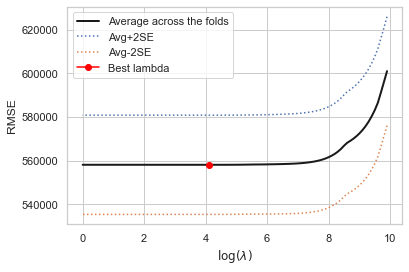

In [29]:
plt.figure()
log_lambdas = np.log(model.alphas_)

avg = np.sqrt(model.mse_path_).mean(axis=-1)
se = np.sqrt(model.mse_path_).std(axis=-1)/np.sqrt(nfolds)

min_index = np.argmin(avg)
print('Best RMSE achieved at log(lambda)=',log_lambdas[min_index])
print('\n   with average RMSE =',avg[min_index], 'and SE=',se[min_index])
plt.plot(log_lambdas,avg, 'k', label='Average across the folds', linewidth=2)
plt.plot(log_lambdas,avg+2*se , ':',label='Avg+2SE')
plt.plot(log_lambdas,avg-2*se , ':',label='Avg-2SE')
plt.plot(log_lambdas[min_index],avg[min_index], marker ='o', color ='red', label = 'Best lambda')

plt.legend()

plt.xlabel('$\log(\lambda)$')  # This is latex syntax
plt.ylabel('RMSE')
plt.axis('tight')
plt.show()

In [30]:
features_names = list(featNames)
features_names.append('intercept')
all_coeff = np.append(model.coef_,model.intercept_)

coefficients_matrix = pd.DataFrame(data = {'Features': features_names, 'Coefficient':all_coeff})

nnz = np.sum(np.abs(all_coeff)>0)
print('There are',nnz,'non-zero coefficients selected by Lasso\n\n', coefficients_matrix.loc[np.abs(all_coeff)>0,:])

There are 131 non-zero coefficients selected by Lasso

                 Features   Coefficient
0        Entradas_Tienda -3.006266e+02
1                  Stock -3.712184e+05
3             Infl Anual -1.396023e+04
7             Semana_W02  9.070329e+02
8             Semana_W03 -1.053621e+03
..                   ...           ...
143        sqrtAbs_Stock  1.015402e+06
147   sqrtAbs_Infl Anual -6.943706e-02
148  log1px2_T Desempleo  3.993251e+03
149  sqrtAbs_T Desempleo  1.861080e+04
154            intercept  3.734609e+05

[131 rows x 2 columns]


### Random Forest

In [32]:
# Use random forest to predict the target variable
from sklearn.ensemble import RandomForestRegressor

# Instantiate model 
rf = RandomForestRegressor()

# Train the model on training data
rf.fit(X_train, y_train);

# Use the forest's predict method on the test data
predRF = rf.predict(X_test)

vRMSE = rmse(y_test,predRF)
print('validation RMSE=',vRMSE)

validation RMSE= 274975.69326226565


In [33]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_train.columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: log1px2_Stock        Importance: 0.11
Variable: Stock                Importance: 0.1
Variable: Entradas_Tienda      Importance: 0.07
Variable: log1px2_Entradas_Tienda Importance: 0.07
Variable: sqrtAbs_Stock        Importance: 0.07
Variable: Tipo_mat_ZFOO        Importance: 0.06
Variable: sqrtAbs_Entradas_Tienda Importance: 0.06
Variable: Tienda_501 - Belsport Virtual Importance: 0.04
Variable: Sexo_Male            Importance: 0.04
Variable: Age_Group_Adult      Importance: 0.04
Variable: Grupo_articulos_NI   Importance: 0.03
Variable: Sexo_Female          Importance: 0.03
Variable: Lugar_E-Commerce     Importance: 0.03
Variable: Grupo_articulos_PM   Importance: 0.02
Variable: Age_Group_Grade School Importance: 0.02
Variable: Dolar                Importance: 0.01
Variable: Semana_W09           Importance: 0.01
Variable: Grupo_articulos_CR   Importance: 0.01
Variable: Grupo_articulos_CV   Importance: 0.01
Variable: Grupo_articulos_FI   Importance: 0.01
Variable: Grupo_articulo

### GBM

In [34]:
# use gbm to predict the target variable
from sklearn.ensemble import GradientBoostingRegressor

# Instantiate model with 1000 decision trees
gbm = GradientBoostingRegressor()

# Train the model on training data
gbm.fit(X_train, y_train)

# Use the predict method on the test data
predGBM = gbm.predict(X_test)

vRMSE = rmse(y_test,predGBM)
print('validation RMSE=',vRMSE)

validation RMSE= 476057.97170938534


### XGBoost

In [36]:
# regression using xgboost
import xgboost as xgb

# Instantiate model with 1000 decision trees
modelXGB = xgb.XGBRegressor(n_estimators=1000)

# Train the model on training data
modelXGB.fit(X_train, y_train)

# Use the predict method on the test data
predXGB = modelXGB.predict(X_test)

vRMSE = rmse(y_test,predXGB)
print('validation RMSE=',vRMSE)

validation RMSE= 284880.4924982542


### CatBoost

In [37]:
# regression using catboost
from catboost import CatBoostRegressor

# Instantiate model with 1000 decision trees
cat = CatBoostRegressor(n_estimators=10000, verbose=False)

# Train the model on training data
cat.fit(X_train, y_train)

# Use the predict method on the test data
predCAT = cat.predict(X_test)

vRMSE = rmse(y_test,predCAT)
print('validation RMSE=',vRMSE)


validation RMSE= 296104.36488459416


## 5-Fold Cross Validation

In [23]:
nFolds = 5

kf = KFold(n_splits=nFolds, random_state=None, shuffle=True)

RMSEList = pd.DataFrame(columns = ['RF_RMSE','XGB_RMSE','CATBOOST_RMSE'])
RMSEList.RF_RMSE = np.zeros(nFolds)
RMSEList.XGB_RMSE = np.zeros(nFolds)
RMSEList.CATBOOST_RMSE = np.zeros(nFolds)


i=0
for train_index, valid_index in kf.split(dataProcessed):
    
    train_cv = dataProcessed.iloc[train_index,:]
    valid_cv = dataProcessed.iloc[valid_index,:]
    

    # Random Forest Model
    modelRF = RandomForestRegressor(n_estimators=100)
    RFtrain_cv = modelRF.fit(train_cv.loc[:,featNames],train_cv['Venta Bruta '])
    validProbsRF_cv  = RFtrain_cv.predict(valid_cv.loc[:,featNames])
    validProbsRF_cv = validProbsRF_cv.reshape(validProbsRF_cv.shape[0], )
    RMSEList.RF_RMSE[i]= rmse(valid_cv['Venta Bruta '], validProbsRF_cv)
    
    # XGB Model
    modelXGB = xgb.XGBRegressor(n_estimators=1000)
    XGBtrain_cv = modelXGB.fit(train_cv.loc[:,featNames],train_cv['Venta Bruta '])
    validationProbsXGB  = XGBtrain_cv.predict(valid_cv.loc[:,featNames])
    validationProbsXGB = validationProbsXGB.reshape(validationProbsXGB.shape[0], )
    RMSEList.XGB_RMSE[i]= rmse(valid_cv['Venta Bruta '], validationProbsXGB)
    
    # CatBoost Model
    modelCB = CatBoostRegressor(iterations=100, verbose=False)
    CBtrain_cv = modelCB.fit(train_cv.loc[:,featNames],train_cv['Venta Bruta '])
    probsCB  = CBtrain_cv.predict(valid_cv.loc[:,featNames])
    probsCB = probsCB.reshape(probsCB.shape[0], )
    RMSEList.CATBOOST_RMSE[i]= rmse(valid_cv['Venta Bruta '], probsCB)  
    
    i = i + 1
    print('Finished fold',i)

Finished fold 1
Finished fold 2
Finished fold 3
Finished fold 4
Finished fold 5


In [24]:
print('     RF avg RMSE =',np.round(np.mean(RMSEList.RF_RMSE),4),
      ' and SE(RMSE) =', np.round(np.std(RMSEList.RF_RMSE)/np.sqrt(nFolds),4) )
print('     XGB avg RMSE =',np.round(np.mean(RMSEList.XGB_RMSE),4),
      ' and SE(RMSE) =', np.round(np.std(RMSEList.XGB_RMSE)/np.sqrt(nFolds),4) )
print('Catboost avg RMSE =',np.round(np.mean(RMSEList.CATBOOST_RMSE),4),
      ' and SE(RMSE) =', np.round(np.std(RMSEList.CATBOOST_RMSE)/np.sqrt(nFolds),4) )
RMSEList

     RF avg RMSE = 285372.3053  and SE(RMSE) = 650.2423
     XGB avg RMSE = 281789.0231  and SE(RMSE) = 2577.7385
Catboost avg RMSE = 335806.4522  and SE(RMSE) = 2601.3298


,RF_RMSE,XGB_RMSE,CATBOOST_RMSE
0,287977.165217,288100.663818,339796.170506
1,283968.358169,273952.696823,330475.936248
2,284274.145450,287419.094061,341561.380701
3,285869.918257,276218.605099,327197.075125
4,284771.939428,283254.055557,340001.698386


## Neural Network

In [40]:
# Neural Network regression
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# create model
model = Sequential()
model.add(Dense(1000, input_dim=featNames.size, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(50, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
# Compile model
model.compile(loss = root_mean_squared_error, optimizer='adam')

print(model.summary())
print('Stay tuned, we are now training the model ...')

history = model.fit(X_train, y_train, epochs = 30, verbose = True, validation_data=(X_test, y_test))
preds = model.predict(X_test)
preds = preds.reshape(preds.shape[0], )
print('RMSE =', rmse(y_test,preds))




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1000)              155000    
                                                                 
 dense_5 (Dense)             (None, 100)               100100    
                                                                 
 dense_6 (Dense)             (None, 50)                5050      
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 260,201
Trainable params: 260,201
Non-trainable params: 0
_________________________________________________________________
None
Stay tuned, we are now training the model ...
Epoch 1/30


NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_6' defined at (most recent call last):
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 619, in start
      self.io_loop.start()
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/tornado/ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
      ret = callback()
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/tornado/gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 358, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 536, in execute_request
      self.do_execute(
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 302, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 539, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-40-f5ac175dae71>", line 25, in <module>
      history = model.fit(X_train, y_train, epochs = 30, verbose = True, validation_data=(X_test, y_test))
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/Users/sebage/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_6'
could not find registered platform with id: 0x3912ac0c0
	 [[{{node StatefulPartitionedCall_6}}]] [Op:__inference_train_function_2133]

In [39]:
# list all data in history
print(history.history.keys())

NameError: name 'history' is not defined

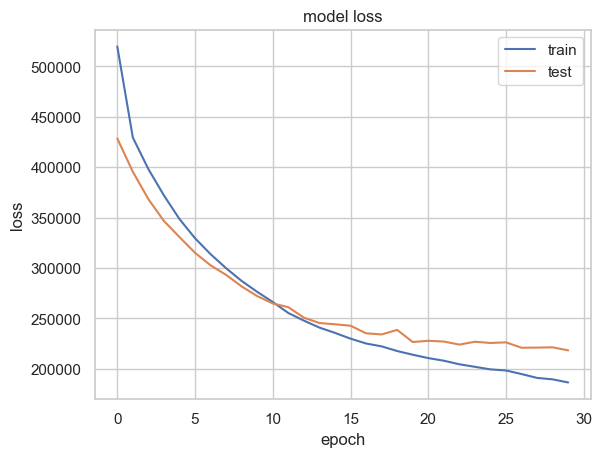

In [40]:
#plot loss vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Results Total

In [42]:
predANNFinal = model.predict(dataProcessed.loc[:,featNames])

# Get sum of all predictions
predANNFinal = predANNFinal.reshape(predANNFinal.shape[0], )
predANNFinal = np.sum(predANNFinal)

print('Total predicted sales =',predANNFinal)

1705/1705 [==============================] - 3s 2ms/step
Total predicted sales = 20336572000.0


In [43]:
#Get sum of all actual sales
actualSales = dataProcessed['Venta Bruta ']
actualSales = np.sum(actualSales)

print('Total actual sales =',actualSales)

Total actual sales = 20361279082.0


In [44]:
#Get percentage error
print('Percentage error =',np.round(100*(predANNFinal-actualSales)/actualSales,2),'%')

Percentage error = -0.12 %


## Results by Week

In [53]:
#Create a dataframe to store predicted sales, actual sales and percentage error
resultsW = pd.DataFrame(columns=['Week','Predicted Sales','Actual Sales','Percentage Error'])

for i in range(1, 13):
    if(i<10):
        week="W0"+str(i)
    else:
        week="W"+str(i)

    indicesW = df[df['Semana'] == week].index

    predANNWeek = model.predict(dataProcessed.loc[indicesW,featNames])
    predANNWeek = predANNWeek.reshape(predANNWeek.shape[0], )

    # Get actual sales for W01
    actualSalesWeek= dataProcessed.loc[indicesW,'Venta Bruta ']
    actualSalesWeek = np.sum(actualSalesWeek)

    # Store predicted sales, actual sales and percentage error in dataframe
    resultsW = resultsW.append({'Week':week,'Predicted Sales':np.sum(predANNWeek),'Actual Sales':actualSalesWeek,'Percentage Error':np.round(100*(np.sum(predANNWeek)-actualSalesWeek)/actualSalesWeek,2)}, ignore_index=True)

resultsW


139/139 [==============================] - 0s 2ms/step


,Week,Predicted Sales,Actual Sales,Percentage Error
0,W01,1.193322e+09,1.230103e+09,-2.99
1,W02,1.075449e+09,1.153976e+09,-6.80
2,W03,1.150337e+09,1.125203e+09,2.23
3,W04,1.249344e+09,1.227007e+09,1.82
4,W05,1.656773e+09,1.690819e+09,-2.01
5,W06,1.760283e+09,1.706535e+09,3.15
6,W07,2.026632e+09,1.987334e+09,1.98
7,W08,2.520677e+09,2.600788e+09,-3.08
8,W09,3.644278e+09,3.595522e+09,1.36
9,W10,1.602594e+09,1.611867e+09,-0.58
